这一个代码的主要目标是对数据进行预处理，现在一共获得了大约9万多条蛋白质数据，需要获取uniprot ID对应的蛋白质序列，并从这些序列中计算出pssm矩阵，使用psi-blast工具进行计算。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.chdir('/data/zhangjian/graduate_project/dataset_for_Tm/high-data/result_high_data')

In [2]:
#以五度为间隔绘制蛋白质熔融温度Tm的分布图。
import math
def nearest_multiple_of_5(number):
    # 将给定数值除以5并向下取整
    nearest_multiple = math.floor(number / 5) * 5
    return nearest_multiple

# 绘制条形图
def plot_raw(data,log=False):
    # 划分区段
    bins = range(nearest_multiple_of_5(data['Tm'].min())+1, int(data['Tm'].max()) + 6, 5)
    # 计算每个分组中的蛋白质数量
    counts, bin_edges = np.histogram(data['Tm'], bins=bins)
    # 对数量进行对数变换
    if log == True:
        counts_log = np.log10(counts)
        counts = counts_log
    plt.figure(figsize=(10, 6))
    bars = plt.bar(range(len(counts)), counts, color='skyblue')
    plt.bar(range(len(counts)), counts, color='skyblue')
    plt.title('Protein Count in  high data')
    plt.xlabel('Tm Result Bins')
    

    
    if log == True:
        for i, bar in enumerate(bars):
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{counts_log[i]:.2f}",
                 ha='center', va='bottom')
        plt.yticks(np.arange(0, np.floor(counts_log.max()) + 1, 1))
        plt.ylabel('log(Protein Count)')
        plt.xticks(range(len(bins)-1), [f'{bins[i]}-{bins[i+1]-1}' for i in range(len(bins)-1)], rotation=45, ha='right')
    if log == False:
        for i, bar in enumerate(bars):
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{counts[i]}",
                     ha='center', va='bottom')
        #plt.yticks(np.arange(0, np.floor(counts.max()) + 1, 1))
        plt.ylabel('Protein Count')
        plt.xticks(range(len(bins)-1), [f'{bins[i]}-{bins[i+1]-1}' for i in range(len(bins)-1)], rotation=45, ha='right')
    plt.show()


In [3]:
Tm_sum = pd.read_csv('Tm_sum.csv')
OGT_sum = pd.read_csv('OGT_sum.csv')

In [4]:
#将OGT大于60的蛋白质数据添加到蛋白质熔融温度之中。
#选择60度作为高稳蛋白和低稳蛋白的分界线。
Tm_sum = Tm_sum[['Uniprot_ID','Tm']]
Tm_high = Tm_sum[Tm_sum['Tm']>60]
Tm_low = Tm_sum[Tm_sum['Tm']<60]
OGT_sum = OGT_sum[['Uniprot_ID','ogt']]
OGT_sum.columns = ['Uniprot_ID','Tm']
OGT_high = OGT_sum[OGT_sum['Tm']>60]

In [5]:
Tm_data = pd.concat([Tm_high,Tm_low,OGT_high],axis=0)
Tm_data['Uniprot_ID_First_Part'] = Tm_data['Uniprot_ID'].apply(lambda x: x.split('_')[0])
handle_Tm = Tm_data.drop_duplicates(subset='Uniprot_ID_First_Part')
handle_Tm = handle_Tm.reset_index(drop=True)

In [6]:
import pandas as pd
import requests
from io import BytesIO
import gzip
def sequence_get(input_data):

    species_ID = input_data
    #这一部分的网址url需要根据自己的需要进行调整。
    #url = f'https://rest.uniprot.org/uniprotkb/stream?compressed=true&download=true&fields=accession%2Cid%2Cprotein_name%2Corganism_name%2Clength&format=tsv&query=%28%28organism_id%3A{species_ID}%29%29+AND+%28reviewed%3Atrue%29%29'
    #url = f'https://rest.uniprot.org/uniparc/stream?compressed=true&download=true&fields=upi%2Csequence&format=tsv&query=%28{species_ID}%29'
    #url = f'https://rest.uniprot.org/uniprotkb/stream?compressed=true&download=true&fields=accession%2Csequence&format=tsv&query=%28%28accession%3A{species_ID}%29%29'
    url = f'https://rest.uniprot.org/uniprotkb/stream?compressed=true&download=true&fields=accession%2Csequence&format=tsv&query=%28%28accession%3A{species_ID}%29%29'
    response = requests.get(url)

    if response.status_code == 200:
         # 从响应中解压缩数据
        with gzip.GzipFile(fileobj=BytesIO(response.content), mode='rb') as f:
        # 读取解压缩后的数据并创建DataFrame
            temp = pd.read_csv(f, sep='\t')
            if temp.shape[0]==0:
                print(f'No result for {species_ID}')
            elif temp.shape[0]==1:
                return temp.loc[0,'Sequence']          
    else:
        print(f"no found for {species_ID}")
        pass
    
#例子
sequence_get('P02294')#获得单独uniprot_ID的序列
handle_Tm['Sequence'] = handle_Tm['Uniprot_ID_First_Part'].apply(squence_get)#批量获得一个dataframe中一列uniprot ID对应的序列。

In [ ]:
handle_Tm['Sequence'] = handle_Tm['Uniprot_ID_First_Part'].apply(squence_get)

No result for P02294;P02293
No result for P04911;P04912
No result for P0A832;C3UPD1


In [65]:
#handle_Tm.to_csv('Tm_final.csv')

In [72]:
handle_Tm.loc[~handle_Tm['Sequence'].notna(),'Sequence'] = handle_Tm.loc[~handle_Tm['Sequence'].notna(),'Uniprot_ID_First_Part'].apply(sequence_get)

No result for B4E1K7
No result for E9PB14
No result for F5H801
no found for P02294;P02293
no found for P04911;P04912
no found for P0A832;C3UPD1
No result for Q5SHP7
No result for Q5SHQ1
no found for set
No result for A0A0J9YIW4
No result for A0A0R4ID52
No result for A0A0R4ISB3
No result for A3KGQ6
No result for B0S5S6
No result for B1ATD2
No result for B4DEM7
No result for B7Z4K6
No result for D3YW87
No result for D3YWS2
No result for E7F8Y5
No result for E7F9F6
No result for E7FCA3
No result for E7FG56
No result for E9PAL9
No result for E9PBJ5
No result for E9PD78
No result for E9PSH2
No result for E9PVY8
No result for E9PYB0
No result for E9Q8F1
No result for E9QG37
No result for F1QAP2
No result for F1QLT6
No result for F1QSY7
No result for F5GZD0
No result for F5H1Z9
No result for F6WYQ5
No result for F7ASG0
No result for G8JLD5
No result for H2L075
No result for H2L0N6
No result for J3KMM5
No result for O02065
No result for O17244
No result for O44128
No result for O44537
No resul

In [75]:
data_Tm2 = handle_Tm[handle_Tm['Sequence'].notna()]
data_Tm1 = pd.read_csv('Tm_final.csv')
data_Tm1 = data_Tm1[data_Tm1['Sequence'].notna()]
list1 = list(data_Tm1['Uniprot_ID_First_Part'])
data2_left = data_Tm2[~data_Tm2['Uniprot_ID_First_Part'].isin(list1)]

In [79]:
#data2_left.to_csv('Tm_left.csv')

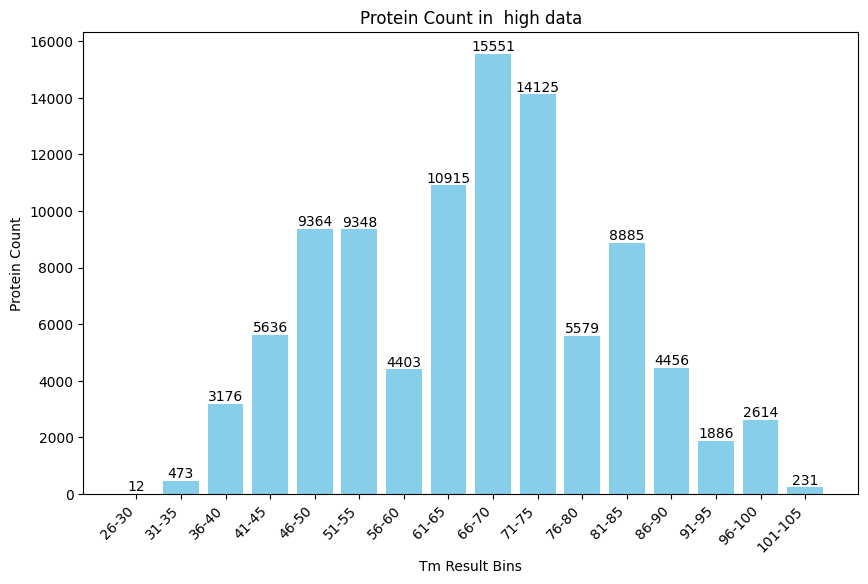

In [81]:
plot_raw(data_Tm2)

In [90]:
data_Tm2_sum = data_Tm2[data_Tm2['Sequence'].notna()]
data_Tm2_sum['length'] = data_Tm2_sum['Sequence'].apply(len)

In [ ]:
import pandas as pd
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord


# 定义一个函数，用于将DataFrame中的数据保存为fasta文件
def save_fasta_from_dataframe(dataframe, id_column, sequence_column, output_file):
    records = []
    for index, row in dataframe.iterrows():
        sequence_id = row[id_column]
        sequence = row[sequence_column]
        record = SeqRecord(sequence, id=sequence_id, description="")
        records.append(record)
    
    with open(output_file, "w") as output_handle:
        SeqIO.write(records, output_handle, "fasta")


In [ ]:
Tm_sum = pd.read_csv('Tm_final.csv')
Tm_sum1 = Tm_sum[Tm_sum['Sequence'].notna()]
#save_fasta_from_dataframe(Tm_sum1,'Uniprot_ID_First_Part','Sequence','Tm_seq.fasta')
import os
import pandas as pd
import subprocess
from concurrent.futures import ThreadPoolExecutor

def parse_fasta(file_path):
    sequences = {}
    with open(file_path, 'r') as file:
        sequence = ''
        identifier = None
        for line in file:
            if line.startswith('>'):
                if identifier:
                    sequences[identifier] = sequence
                    sequence = ''
                identifier = line.strip()[1:]
            else:
                sequence += line.strip()
        if identifier:
            sequences[identifier] = sequence
    return sequences

def Get_PSSM_single(identifier, sequence, output_dir):
    with open("Temporary.fasta", 'w') as temp_file:
        temp_file.write(f">{identifier}\n{sequence}")
    subprocess.run(['/data/zhangjian/psi-blast/ncbi-blast-2.15.0+/bin/psiblast', '-query', 'Temporary.fasta', '-db', '/data/zhangjian/psi-blast/ncbi-blast-2.15.0+/db/swissprot/swissprot', '-evalue', '0.001', '-num_iterations', '3', '-out_ascii_pssm', os.path.join(output_dir, f"{identifier}.pssm")], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

def Get_PSSM(fasta_file, output_dir):
    sequences = parse_fasta(fasta_file)
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    with ThreadPoolExecutor() as executor:
        futures = []
        for identifier, sequence in sequences.items():
            futures.append(executor.submit(Get_PSSM_single, identifier, sequence, output_dir))
        for future in futures:
            future.result()

fasta_file = "Tm_seq.fasta"  # 输入的FASTA文件路径
output_directory = "pssm3"  # 输出目录
Get_PSSM(fasta_file, output_directory)

In [ ]:
import seaborn as sns

# 设置风格
sns.set(style="whitegrid")

# 绘制曲线图
sns.kdeplot(data=data_all2['Length'], shade=True, color="b")

# 添加标题和标签
plt.title('Length Distribution')
plt.xlabel('Length')
plt.ylabel('Density')
plt.axvline(x=512, color='r', linestyle='--')
# 显示图形
plt.show()

In [ ]:
def load_file(file_path):
    try:
        with open(file_path) as f_in:
            lines = f_in.readlines()
        return lines
    except IOError as err:
        print('Can not open file: ' + file_path)
        return 'nan'

def parse_pssm(filelines, winsize=51, pssm_root=None, mutated_pos=None, most512=False):
    filelines = load_file(os.path.join(pssm_root, filelines + '.pssm'))
    if filelines == 'nan':
        return 'nan'
    pssmvalue = np.array([])
    for line in filelines:
        if len(line.split()) == 44:
            pssmvalue = np.r_[pssmvalue, np.array(line.split()[2:22]).astype(float)]
    pssmvalue = np.reshape(pssmvalue, (-1, 20))
    if pssmvalue.shape[0] < 512:
        pssmvalue = np.r_[pssmvalue, np.zeros([512 - pssmvalue.shape[0], 20])]
    if most1024:
        if pssmvalue.shape[0] > 512:
            pssmvalue = pssmvalue[:512, :]
    if mutated_pos != None:
        pssmvalue = np.r_[np.zeros([25, 20]), pssmvalue, np.zeros([25, 20])]
        pssmvalue = pssmvalue[mutated_pos - 1: mutated_pos + 50, :]
    
    return pssmvalue

In [ ]:
data_all1 = data_all[data_all['Length']>=1024]
ori_pssm_root = 'pssm3'
pssm_par0 = [parse_pssm(x, pssm_root=ori_pssm_root) for x in data_all1['Uniprot_ID_First_Part']]

data_all1['pssm_par0'] = pssm_par0
data_all1 = data_all1[~(data_all1['pssm_par0'] == 'nan')]

In [ ]:
data_handle = pd.concat([data_all2,data_all3],axis=0)
#95136个蛋白质
data_handle.to_pickle('Tm_pssm_final.dataset')

In [ ]:
data_quan = pd.read_pickle('Tm_pssm_final.dataset')
list_uniprot = list(data_quan['Uniprot_ID_First_Part'])
data_left = Tm_sum[~Tm_sum['Uniprot_ID_First_Part'].isin(list_uniprot)]
data_left['Length'] = data_left['Sequence'].apply(len)

In [ ]:
data_left = data_left[data_left['Sequence'].notna()]
data_left['Length'] = data_left['Sequence'].apply(len)

In [ ]:
from Bio import SeqIO
import pandas as pd

# 读取fasta文件
fasta_file = "new.fasta"

# 创建一个空列表来存储每个序列的ID和序列
sequences = []

# 使用Biopython的SeqIO模块遍历fasta文件中的每个序列
for record in SeqIO.parse(fasta_file, "fasta"):
    # 获取序列的Uniprot ID和序列本身
    uniprot_id = record.id
    sequence = str(record.seq)
    
    # 将Uniprot ID和序列存储为元组，并添加到sequences列表中
    sequences.append((uniprot_id, sequence))

# 将sequences列表转换为DataFrame
df = pd.DataFrame(sequences, columns=["Uniprot_ID", "Sequence"])

# 打印DataFrame的前几行
print(df.head())
list_temp = list(df['Uniprot_ID'])
final_data = data_handle[data_handle['Uniprot_ID_First_Part'].isin(list_temp)]

In [ ]:
#final_data.to_pickle('Tm_pssm_cdhit.dataset')

In [ ]:
ori_pssm_root = 'pssm2'
pssm_par0 = [parse_pssm(x, pssm_root=ori_pssm_root) for x in final_data['Uniprot_ID_First_Part']]
# pssm 51 window only available to single mutation items
final_data['pssm_par0'] = pssm_par0
final_data = final_data[~(final_data['pssm_par0'] == 'nan')]

In [ ]:
final_data.to_pickle('new_pssm_cdhit.dataset')